# PSD tests
Some tests to clarify how to calculate the PSD of a signal, randomize it and which results to expect.

**UPDATE: OH MY GOODNESS I have been using the wrong method for computing the PSD all this time along, since Welch's method can only be used for evenly sampled signals. From now on use the Lomb-Scargle periodogram. We also have to use Non-Unifrom Fourier Transform (NFT).**

In [1]:
# I'm doing a lot of changes to MUTIS while writting this, better reload automatically.
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import pi as pi
import scipy as sp
import scipy.signal

import matplotlib as mplt
import matplotlib.pyplot as plt

import mutis

import nfft # non uniform fourier transform

import traceback

## Using NFT and Lomb-Scargle periodogram.

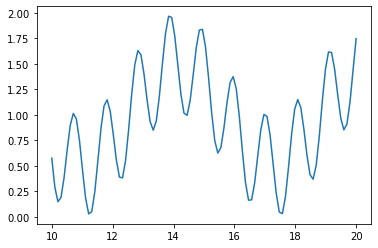

In [3]:
t = np.linspace(10,20,100)
s = 0.5*np.sin(1*t) +0.5*np.sin(6*t)+1

plt.plot(t,s)

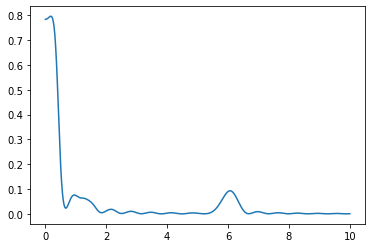

In [4]:
freqs = np.linspace(1e-3,10,1000)
sxx = sp.signal.lombscargle(x=t, y=s, freqs=freqs, normalize=True)

fig, ax = plt.subplots()
ax.plot(freqs, sxx)
plt.show()

In [5]:
"""
def lc_gen_psd_lombscargle(t, sig, pl2, N=None):
    sigp = sig
    tp = t
    
    if sig.size % 2 != 0:
        print('Odd number')
        sigp = sig[:-1]
        tp = t[:-1]
    else:
        sigp = sig
        tp = t
    
    N = sigp.size
    #k = np.arange(-N/2,N/2) no bc sp.signal.lombscargle does not support freq zero:
    k = np.linspace(-N/2,N/2-1+1e-6,N)
    freqs = k/2/pi
    
    Pxx = sp.signal.lombscargle(tp, sigp, freqs)
    
    # construct random phase to get real signal:
    phase = np.random.random(Pxx.size//2)
    phase = np.concatenate((-np.flip(phase),[0], phase[:-1]))
    
    fft2 = np.sqrt(2*Pxx*Pxx.size)*np.exp(1j*2*pi*phase)
    
    sig2 = nfft.nfft((t-(t.max()+t.min())/2)/np.ptp(t), fft2, N, use_fft=True)/N

    #return sig2
    #fix small deviations
    a = (sig.std()/sig2.std())
    b = sig.mean()-a*sig2.mean()
    sig2 = a*sig2+b
    
    return sig2


def lc_gen_psd_nft(t, sig, pl2, N=None):
    k = np.arange(-t.size//2, t.size/2)
    N = k.size
    freqs = k/2/pi
    
    nft = nfft.nfft_adjoint((t-(t.max()+t.min())/2)/np.ptp(t), sig, N, use_fft=True)

    # construct random phase to get real signal:
    phase = np.random.random(N.size//2)
    phase = np.concatenate((-np.flip(phase),[0],phase[:-1]))
    
    fft2 = np.abs(nft)*np.exp(1j*2*pi*phase)
    sig2 = nfft.nfft((t-(t.max()+t.min())/2)/np.ptp(t), fft2, use_fft=True)/N
    
    #return sig2
    sig2 = np.real(sig2)     # np.real to fix small imaginary part from numerical error

    # fix small mean, std difference from numerical error
    a = (sig.std()/sig2.std())
    b = sig.mean()-a*sig2.mean()
    sig2 = a*sig2+b
    
    return sig2
""";

0.9258046721637005
(0.9258046721637005+3.9898639947466565e-19j)
0


/opt/miniconda3/envs/mutis/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/miniconda3/envs/mutis/lib/python3.9/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '


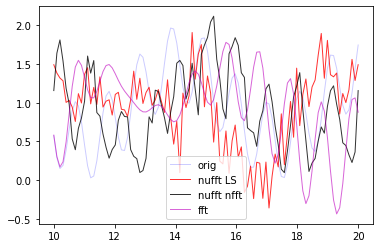

In [6]:
fig, ax = plt.subplots()

ax.plot(t,s,'b-', lw=1, alpha=0.2, label='orig')

#try:
s2 = mutis.signal.lc_gen_psd_lombscargle(t,s)
ax.plot(t,s2, 'r-', lw=1, alpha=0.8, label='nufft LS')

s4 = mutis.signal.lc_gen_psd_nft(t,s)
ax.plot(t,s4, 'k-', lw=1, alpha=0.8, label='nufft nfft')

s3 = mutis.signal.lc_gen_psd_fft(s)
ax.plot(t,s3, 'm-', lw=1, alpha=0.6, label='fft')

ax.legend()

print(np.mean(s))
print(np.mean(s2))
print(np.sum(np.imag(s2)>0.3))

/opt/miniconda3/envs/mutis/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, 'ndft')

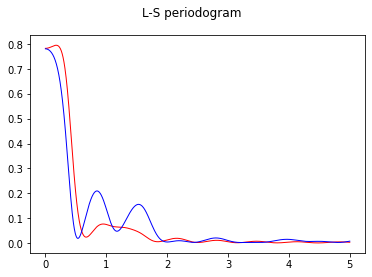

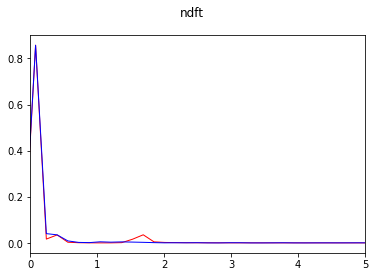

In [7]:
freqs = np.linspace(1e-3,5,1000)
sxx = sp.signal.lombscargle(x=t, y=s, freqs=freqs, normalize=True)
sxx2 = sp.signal.lombscargle(x=t, y=s2, freqs=freqs, normalize=True)


fig, ax = plt.subplots()
ax.plot(freqs, sxx, 'r-', lw=1)
ax.plot(freqs, sxx2, 'b-', lw=1)
fig.suptitle('L-S periodogram')

fig, ax = plt.subplots()

N = s.size
#k = -(N // 2) + np.arange(N)
k = np.linspace(-s.size/2,s.size/2,N)
freqs = k/2/pi
nft = nfft.nfft_adjoint((t-(t.max()+t.min())/2)/np.ptp(t), s, N, use_fft=True)/N
Pxx = np.abs(nft)**2

#idx = np.argsort(freqs)
#freqs = freqs[idx]
#Pxx = Pxx[idx]

#Pxx = sp.fft.ifftshift(Pxx)
#freqs = np.linspace(-0.5, 0.5, N, endpoint=True)*2*pi*4
ax.plot(freqs,Pxx, 'r-', lw=1)

##########
N = s2.size
#k = -(N // 2) + np.arange(N)
k = np.linspace(-s2.size/2,s2.size/2,N)
freqs = k/2/pi
nft = nfft.nfft_adjoint((t-(t.max()+t.min())/2)/np.ptp(t), s2, N, use_fft=True)/N
Pxx = np.abs(nft)**2

#idx = np.argsort(freqs)
#freqs = freqs[idx]
#Pxx = Pxx[idx]

#Pxx = sp.fft.ifftshift(Pxx)
#freqs = np.linspace(-0.5, 0.5, N, endpoint=True)*2*pi*4
ax.plot(freqs,Pxx, 'b-', lw=1)
##########

ax.set_xlim([0, 5])
fig.suptitle('ndft')

### FT and iFT with NDFT

(0.0, 4.0)

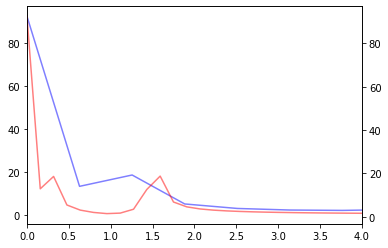

In [8]:
N = s.size
k = -(N // 2) + np.arange(N)
freqs = k/2/pi
nft = nfft.nfft_adjoint((t-(t.max()+t.min())/2)/np.ptp(t), s, N, use_fft=True)

ft = sp.fft.fft(s)

plt.plot(2*pi*np.arange(0,t.size)/np.ptp(t), np.abs(ft), 'b', alpha=0.5)
plt.gca().twinx()
plt.plot(freqs, np.abs(nft), 'r', alpha=0.5)
plt.xlim([0,4])

/opt/miniconda3/envs/mutis/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/miniconda3/envs/mutis/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


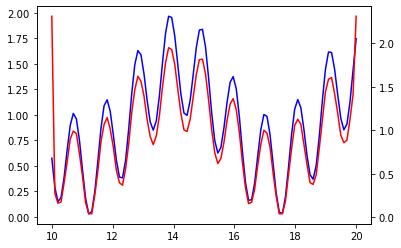

In [9]:
s2nft = 1/N*nfft.nfft((t-(t.max()+t.min())/2)/np.ptp(t), nft, use_fft=True)
s2ft = sp.fft.ifft(ft)
plt.plot(t, s2ft, 'b')
plt.gca().twinx()
plt.plot(t, s2nft, 'r')

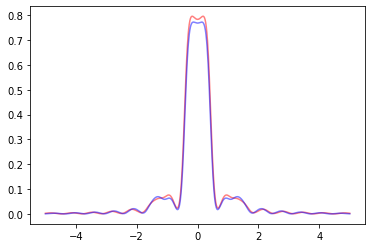

In [10]:
freqs = np.linspace(-5,+5,1000)
sxx_ft = sp.signal.lombscargle(x=t, y=s2ft, freqs=freqs, normalize=True)
sxx_nft = sp.signal.lombscargle(x=t, y=s2nft, freqs=freqs, normalize=True)

fig, ax = plt.subplots()
ax.plot(freqs, sxx_ft, 'r-', alpha=0.5)
ax.plot(freqs, sxx_nft, 'b-', alpha=0.5)
plt.show()